In [1]:
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
import ligo.skymap.plot
from matplotlib import pyplot as plt



In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

import ligo.skymap.io
import healpy as hp
import matplotlib.pyplot as plt

In [3]:


def get_probabilities(skymap, ra, dec, radius=0.35*u.deg):
    """
    Compute the probabilities covered in a grid of ra, dec with radius
    given a healpix skymap

    Pass the legal RA and Dec lists to this function

    Note: this radius is such that for the default sky grid (nside=128),
    fields overlap such that the area of the sky becomes 1.83 * 4pi steradians.
    As a result, the sum of probabilities will be 1.83
    """
    # fact : int, optional
    # Only used when inclusive=True. The overlapping test will be done at
    # the resolution fact*nside. For NESTED ordering, fact must be a power of 2, less than 2**30,
    # else it can be any positive integer. Default: 4.
    fact = 1
    nside_skymap = hp.npix2nside(len(skymap))
    tile_area = np.pi * radius.to(u.deg).value ** 2
    pixel_area = hp.nside2pixarea(nside_skymap, degrees=True)
    probabilities = np.zeros(len(ra))
    vecs = hp.ang2vec(ra.to(u.deg).value, dec.to(u.deg).value, lonlat=True)
    for i in range(len(ra)):
        sel_pix = hp.query_disc(nside_skymap, vecs[i], radius.to(
            u.rad).value, inclusive=True, fact=fact)
        probabilities[i] = np.sum(skymap[sel_pix]) * \
            tile_area / pixel_area / len(sel_pix)
    return probabilities



def get_top_tiles(probabilities, frac=0.99):
    """
    probabilities may not add up to 1
    return indices of tiles that add up to frac of total
    """
    sortorder = np.argsort(probabilities)
    p_cum = np.cumsum(probabilities[sortorder]) / np.sum(probabilities)
    startind = np.where(p_cum > 1 - frac)[0][0]
    top_tiles = sortorder[startind:]
    return np.flip(top_tiles)






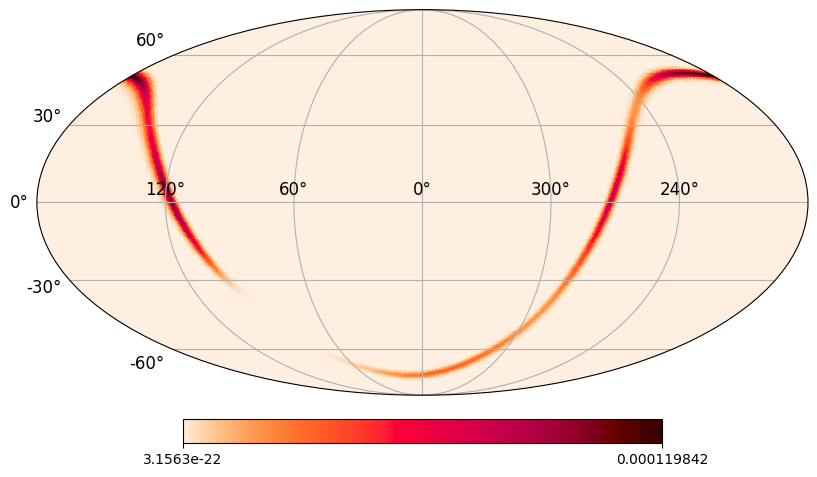

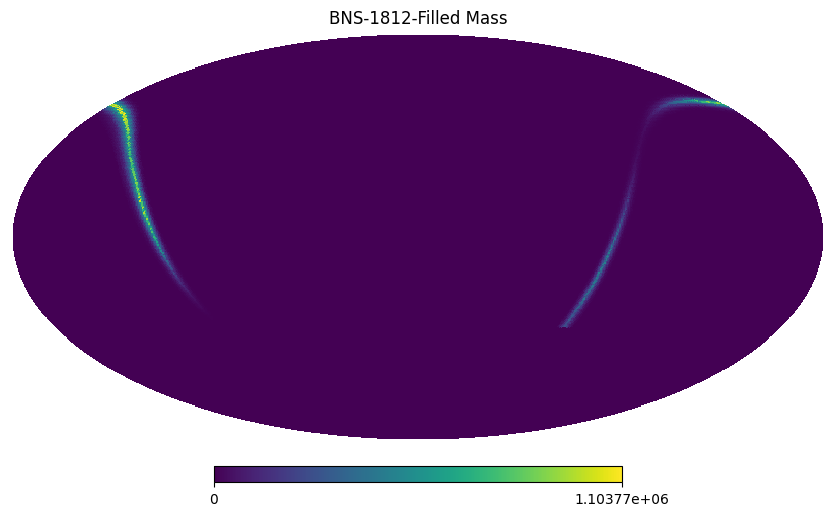

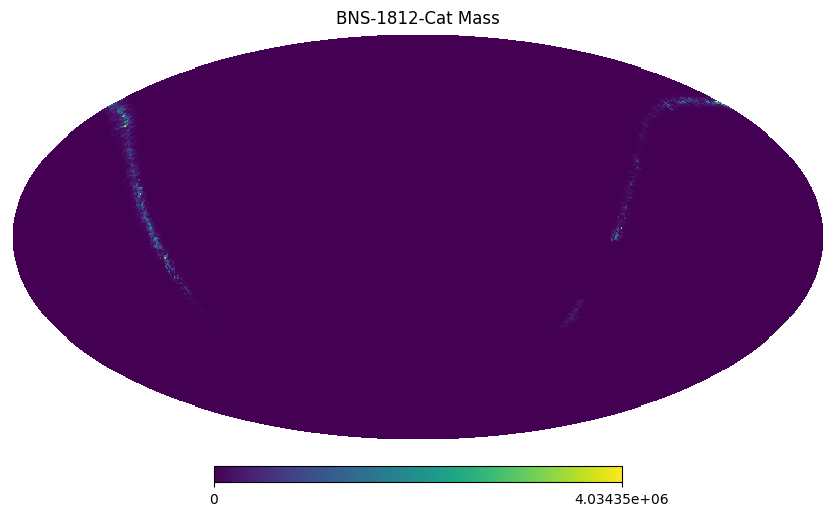

In [4]:
tiles = pd.read_csv('tiles_GIT_7.csv')
ralist, declist = np.array(tiles['RA_Center'])*u.deg, np.array(tiles['DEC_Center'])*u.deg

nside_skymap = 512
radius = 0.35*u.deg
fact = 1

#mapn = 1417
mapn = 1812
for k in [mapn]:
    cs = pd.read_csv('Orderings/Map_{}.csv'.format(k))
    sigma_m_nonempty, sigma_m_empty_nodist, sigma_m_empty_dist = np.array(cs['Filled3D']), np.array(cs['Unfilled2D']), np.array(cs['Unfilled3D'])
    
    cs = pd.read_csv('Orderings-2D-GIT/Map_{}.csv'.format(k))
    sigma_m_empty_nodist, sigma_monly = np.array(cs['Unfilled2D']), np.array(cs['MassOnly_Distcut'])
    
    skym = ligo.skymap.io.fits.read_sky_map('farah/allsky/{}.fits'.format(k), distances=True)
    skymap = hp.ud_grade(skym[0][0], 512)
    probs = get_probabilities(skymap, ralist, declist)
    tt = get_top_tiles(probs)
    
    z1 = np.zeros(12*512**2)
    z2 = np.zeros(12*512**2)
    z_3dfill = np.zeros(12*512**2)
    z_2dcat = np.zeros(12*512**2)
    z_3dcat = np.zeros(12*512**2)
    z_massonly = np.zeros(12*512**2)
    z_2dp = np.zeros(12*512**2)
    
    fullsum = np.sum(sigma_m_nonempty)
    
    rings = np.zeros(12*512**2)
    col = np.max(skymap)*5
    
    for h in range(-1,-len(tt)-1,-1):
        ra = ralist[tt[h]]
        dec = declist[tt[h]]
        vecs = hp.ang2vec(ra.to(u.deg).value, dec.to(u.deg).value, lonlat=True)
        sel_pix = hp.query_disc(nside_skymap, vecs, radius.to(u.rad).value, inclusive=True, fact=fact)
        in_pix = hp.query_disc(nside_skymap, vecs, radius.to(u.rad).value, inclusive=False, fact=fact)
        rings[sel_pix] = col
        rings[in_pix] = skymap[in_pix]
        z1[sel_pix] = (sigma_m_nonempty - sigma_m_empty_dist)[h]#/fullsum
        z2[sel_pix] = (sigma_m_empty_dist)[h]#/fullsum
        z_2dcat[sel_pix] = (sigma_m_empty_nodist)[h]
        z_3dcat[sel_pix] = (sigma_m_empty_dist)[h]
        z_3dfill[sel_pix] = (sigma_m_nonempty)[h]
        z_massonly[sel_pix] = sigma_monly[h]
        z_2dp[sel_pix] = np.mean(skymap[sel_pix])
    
    hp.projview(skymap, cmap='cylon', coord=["G"], graticule=True, graticule_labels=True, projection_type="mollweide")
    #plt.grid()
    #plt.title('BNS-{}-Original'.format(k))
    plt.show()
    hp.mollview(z1)
    plt.title('BNS-{}-Filled Mass'.format(k))
    plt.show()
    hp.mollview(z2)
    plt.title('BNS-{}-Cat Mass'.format(k))
    plt.show()

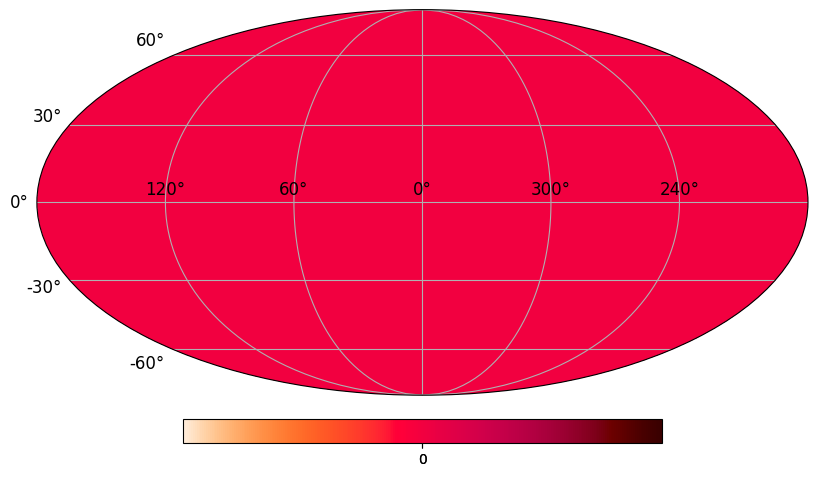

In [9]:
hp.projview(skymap*0, cmap='cylon', coord=["G"], graticule=True, graticule_labels=True, projection_type="mollweide")
#plt.grid()
#plt.title('BNS-{}-Original'.format(k))
plt.show()

/tmp/ipykernel_162/337305205.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


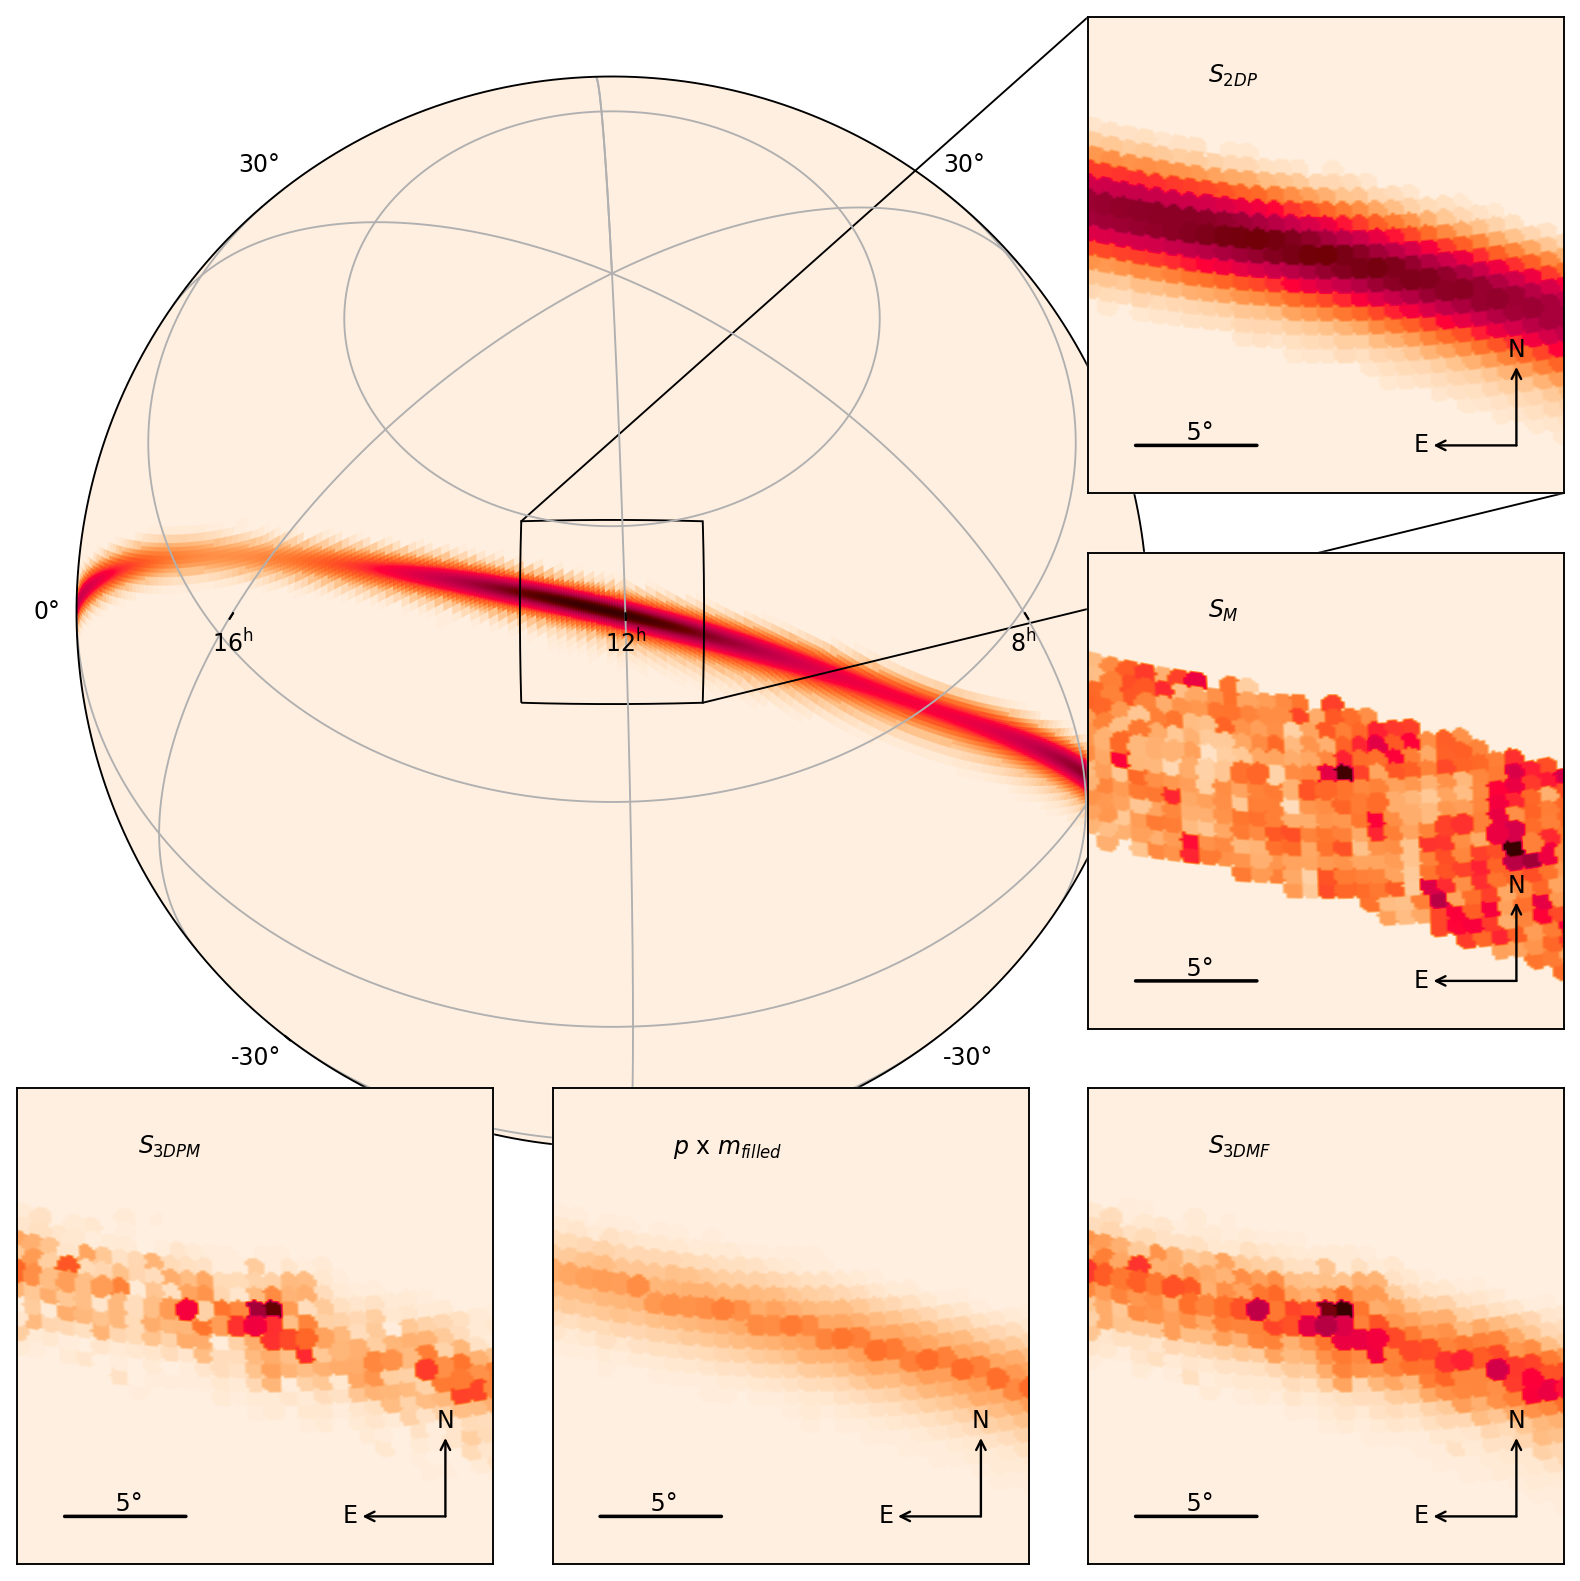

In [6]:
z_catmass, z_missmass = z2, z1

rad = 10

center = SkyCoord(ralist[tt[0]], declist[tt[0]], unit='deg')
fig = plt.figure(figsize=(7, 7), dpi=170)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset1 = plt.axes(
    [0.9, 0.6, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,410, '$S_{2DP}$')

for key in ['ra', 'dec']:
    ax_inset1.coords[key].set_ticklabel_visible(False)
    ax_inset1.coords[key].set_ticks_visible(False)
#ax.grid()
ax.mark_inset_axes(ax_inset1)
#ax.connect_inset_axes(ax_inset1, 'upper left')
#ax.connect_inset_axes(ax_inset1, 'lower right')
ax_inset1.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset1.compass(0.9, 0.1, 0.2)


ax_inset2 = plt.axes(
    [0.9, 0.15, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,410, '$S_{M}$')

for key in ['ra', 'dec']:
    ax_inset2.coords[key].set_ticklabel_visible(False)
    ax_inset2.coords[key].set_ticks_visible(False)
ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset2.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset2.compass(0.9, 0.1, 0.2)



ax_inset3 = plt.axes(
    [0.45, -0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,410, '$p$ x $m_{filled}$')

for key in ['ra', 'dec']:
    ax_inset3.coords[key].set_ticklabel_visible(False)
    ax_inset3.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset3.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset3.compass(0.9, 0.1, 0.2)


ax_inset4 = plt.axes(
    [-0.0, -0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,410, '$S_{3DPM}$')

for key in ['ra', 'dec']:
    ax_inset4.coords[key].set_ticklabel_visible(False)
    ax_inset4.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset4.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset4.compass(0.9, 0.1, 0.2)



ax_inset5 = plt.axes(
    [0.9, -0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,410, '$S_{3DMF}$')

for key in ['ra', 'dec']:
    ax_inset5.coords[key].set_ticklabel_visible(False)
    ax_inset5.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset1, 'upper left')
ax.connect_inset_axes(ax_inset1, 'lower right')
ax_inset5.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset5.compass(0.9, 0.1, 0.2)




cm = 'cylon'
ax.imshow_hpx(skymap, cmap=cm)
vm = np.max(z_3dfill)
ax_inset2.imshow_hpx(z_massonly, cmap=cm)#, vmin=0,vmax=vm)
ax_inset1.imshow_hpx(z_2dp, cmap=cm, vmin=0,vmax=np.max(skymap)*1.1)
ax_inset3.imshow_hpx(z_missmass, cmap=cm, vmin=0,vmax=vm)
ax_inset4.imshow_hpx(z_catmass, cmap=cm, vmin=0,vmax=vm)
ax_inset5.imshow_hpx(z_3dfill, cmap=cm, vmin=0,vmax=vm)
plt.tight_layout()
plt.savefig('globe6.pdf')
#ax.colorbar()

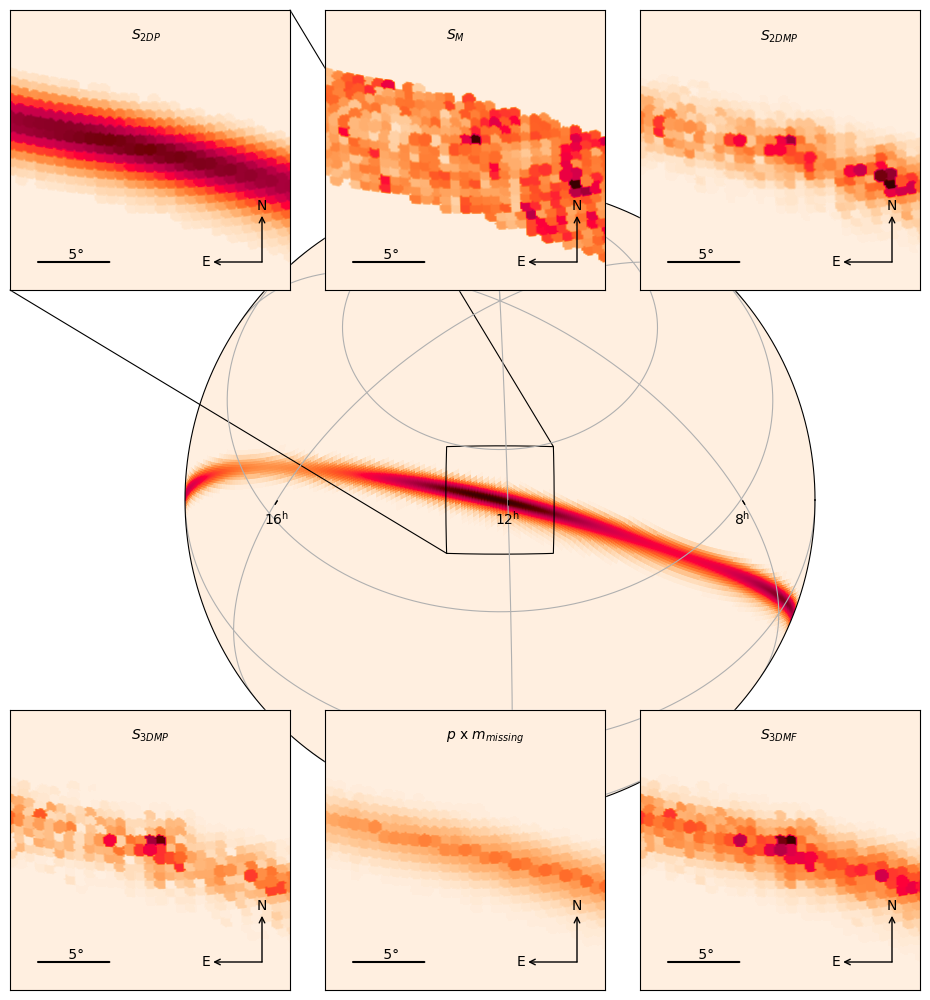

In [6]:
z_catmass, z_missmass = z2, z1

rad = 10

center = SkyCoord(ralist[tt[0]], declist[tt[0]], unit='deg')
fig = plt.figure(figsize=(7, 7), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset1 = plt.axes(
    [0.7, 0.8, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$S_{2DMP}$')

for key in ['ra', 'dec']:
    ax_inset1.coords[key].set_ticklabel_visible(False)
    ax_inset1.coords[key].set_ticks_visible(False)
#ax.grid()
ax.mark_inset_axes(ax_inset1)
#ax.connect_inset_axes(ax_inset1, 'upper left')
#ax.connect_inset_axes(ax_inset1, 'lower right')
ax_inset1.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset1.compass(0.9, 0.1, 0.2)


ax_inset2 = plt.axes(
    [-0.2, 0.8, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$S_{2DP}$')

for key in ['ra', 'dec']:
    ax_inset2.coords[key].set_ticklabel_visible(False)
    ax_inset2.coords[key].set_ticks_visible(False)
ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset2.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset2.compass(0.9, 0.1, 0.2)



ax_inset3 = plt.axes(
    [0.25, -0.2, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$p$ x $m_{missing}$')

for key in ['ra', 'dec']:
    ax_inset3.coords[key].set_ticklabel_visible(False)
    ax_inset3.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset3.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset3.compass(0.9, 0.1, 0.2)


ax_inset4 = plt.axes(
    [-0.2, -0.2, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$S_{3DMP}$')

for key in ['ra', 'dec']:
    ax_inset4.coords[key].set_ticklabel_visible(False)
    ax_inset4.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset4.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset4.compass(0.9, 0.1, 0.2)



ax_inset5 = plt.axes(
    [0.7, -0.2, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$S_{3DMF}$')

for key in ['ra', 'dec']:
    ax_inset5.coords[key].set_ticklabel_visible(False)
    ax_inset5.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset2, 'upper right')
ax.connect_inset_axes(ax_inset2, 'lower left')
ax_inset5.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset5.compass(0.9, 0.1, 0.2)



ax_inset6 = plt.axes(
    [0.25, 0.8, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$S_{M}$')

for key in ['ra', 'dec']:
    ax_inset6.coords[key].set_ticklabel_visible(False)
    ax_inset6.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)
#ax.connect_inset_axes(ax_inset5, 'upper right')
#ax.connect_inset_axes(ax_inset5, 'lower left')
ax_inset6.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset6.compass(0.9, 0.1, 0.2)




cm = 'cylon'
ax.imshow_hpx(skymap, cmap=cm)
vm = np.max(z_3dfill)
ax_inset1.imshow_hpx(z_2dcat, cmap=cm)#, vmin=0,vmax=vm)
ax_inset2.imshow_hpx(z_2dp, cmap=cm, vmin=0,vmax=np.max(skymap)*1.1)
ax_inset3.imshow_hpx(z_missmass, cmap=cm, vmin=0,vmax=vm)
ax_inset4.imshow_hpx(z_catmass, cmap=cm, vmin=0,vmax=vm)
ax_inset5.imshow_hpx(z_3dfill, cmap=cm, vmin=0,vmax=vm)
ax_inset6.imshow_hpx(z_massonly, cmap=cm)
#ax.colorbar()
plt.savefig('globe4.pdf')

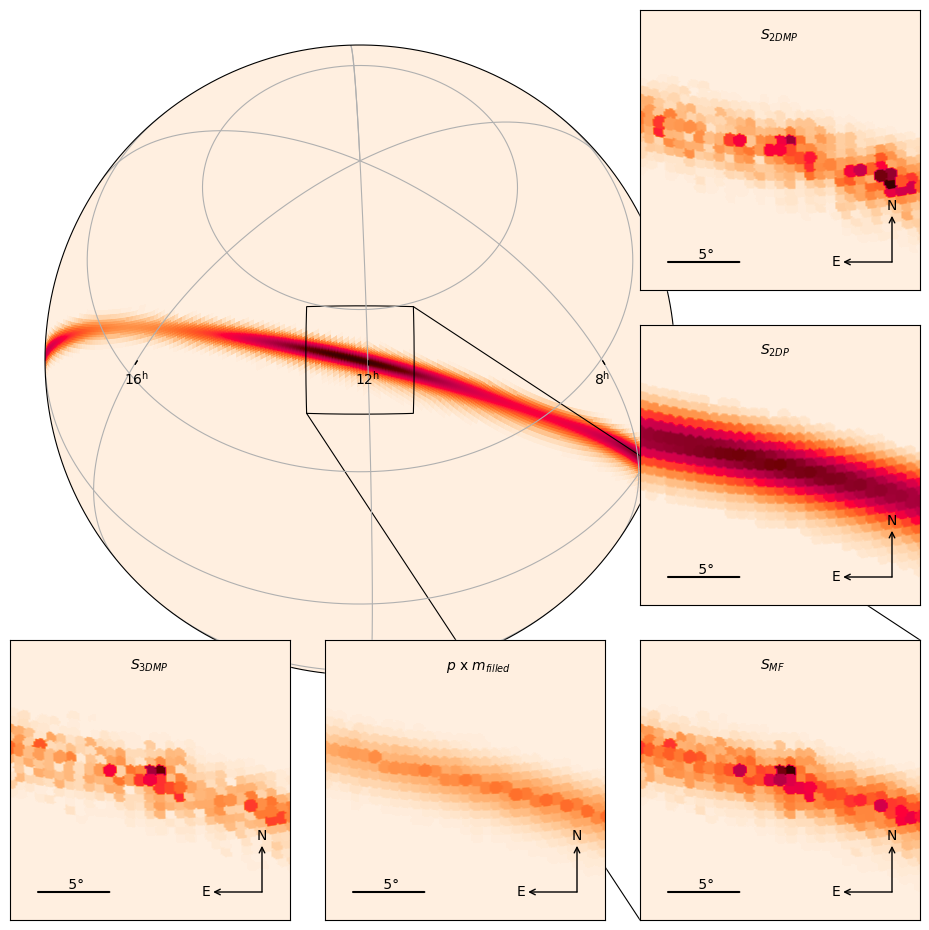

In [11]:
z_catmass, z_missmass = z2, z1

rad = 10

center = SkyCoord(ralist[tt[0]], declist[tt[0]], unit='deg')
fig = plt.figure(figsize=(7, 7), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset1 = plt.axes(
    [0.9, 0.6, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$S_{2DMP}$')

for key in ['ra', 'dec']:
    ax_inset1.coords[key].set_ticklabel_visible(False)
    ax_inset1.coords[key].set_ticks_visible(False)
#ax.grid()
ax.mark_inset_axes(ax_inset1)
#ax.connect_inset_axes(ax_inset1, 'upper left')
#ax.connect_inset_axes(ax_inset1, 'lower right')
ax_inset1.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset1.compass(0.9, 0.1, 0.2)


ax_inset2 = plt.axes(
    [0.9, 0.15, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$S_{2DP}$')

for key in ['ra', 'dec']:
    ax_inset2.coords[key].set_ticklabel_visible(False)
    ax_inset2.coords[key].set_ticks_visible(False)
ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset2.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset2.compass(0.9, 0.1, 0.2)



ax_inset3 = plt.axes(
    [0.45, -0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$p$ x $m_{filled}$')

for key in ['ra', 'dec']:
    ax_inset3.coords[key].set_ticklabel_visible(False)
    ax_inset3.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset3.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset3.compass(0.9, 0.1, 0.2)


ax_inset4 = plt.axes(
    [-0.0, -0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$S_{3DMP}$')

for key in ['ra', 'dec']:
    ax_inset4.coords[key].set_ticklabel_visible(False)
    ax_inset4.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset4.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset4.compass(0.9, 0.1, 0.2)



ax_inset5 = plt.axes(
    [0.9, -0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$S_{MF}$')

for key in ['ra', 'dec']:
    ax_inset5.coords[key].set_ticklabel_visible(False)
    ax_inset5.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset5, 'upper right')
ax.connect_inset_axes(ax_inset5, 'lower left')
ax_inset5.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset5.compass(0.9, 0.1, 0.2)




cm = 'cylon'
ax.imshow_hpx(skymap, cmap=cm)
vm = np.max(z_3dfill)
ax_inset1.imshow_hpx(z_2dcat, cmap=cm)#, vmin=0,vmax=vm)
ax_inset2.imshow_hpx(z_2dp, cmap=cm, vmin=0,vmax=np.max(skymap)*1.1)
ax_inset3.imshow_hpx(z_missmass, cmap=cm, vmin=0,vmax=vm)
ax_inset4.imshow_hpx(z_catmass, cmap=cm, vmin=0,vmax=vm)
ax_inset5.imshow_hpx(z_3dfill, cmap=cm, vmin=0,vmax=vm)
#ax.colorbar()

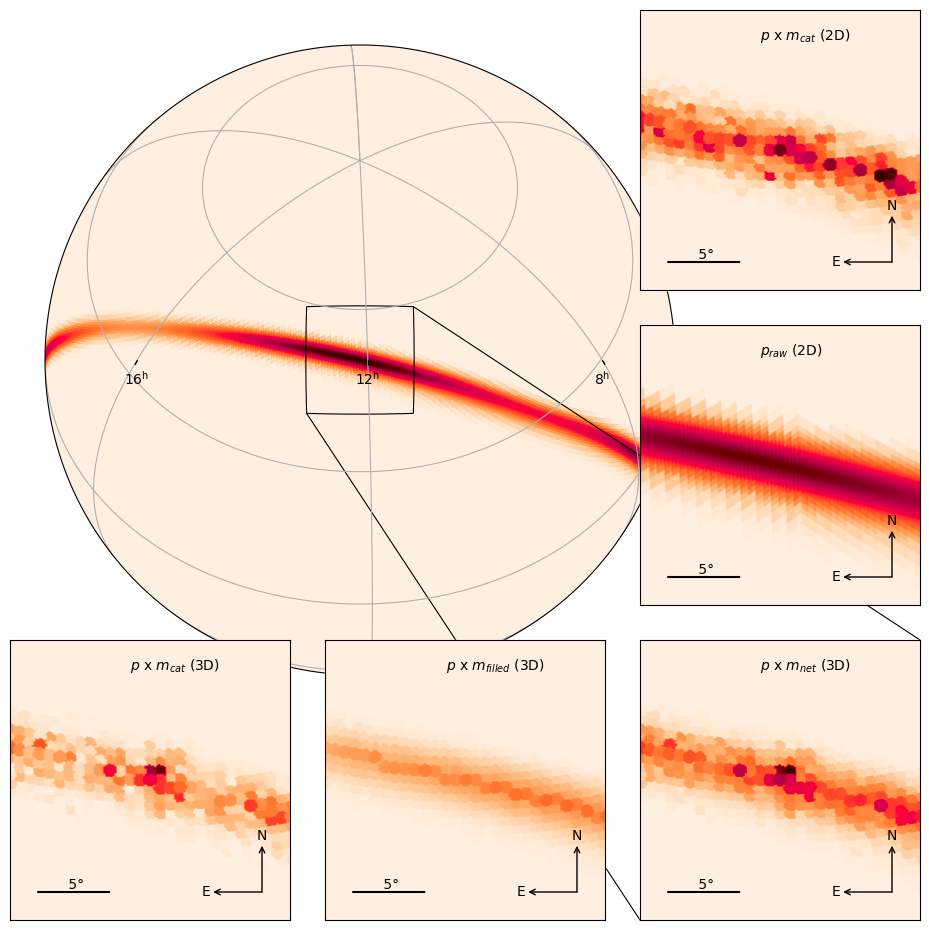

In [8]:
z_catmass, z_missmass = z2, z1

rad = 10

center = SkyCoord(ralist[tt[0]], declist[tt[0]], unit='deg')
fig = plt.figure(figsize=(7, 7), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset1 = plt.axes(
    [0.9, 0.6, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$p$ x $m_{cat}$ (2D)')

for key in ['ra', 'dec']:
    ax_inset1.coords[key].set_ticklabel_visible(False)
    ax_inset1.coords[key].set_ticks_visible(False)
#ax.grid()
ax.mark_inset_axes(ax_inset1)
#ax.connect_inset_axes(ax_inset1, 'upper left')
#ax.connect_inset_axes(ax_inset1, 'lower right')
ax_inset1.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset1.compass(0.9, 0.1, 0.2)


ax_inset2 = plt.axes(
    [0.9, 0.15, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$p_{raw}$ (2D)')

for key in ['ra', 'dec']:
    ax_inset2.coords[key].set_ticklabel_visible(False)
    ax_inset2.coords[key].set_ticks_visible(False)
ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset2.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset2.compass(0.9, 0.1, 0.2)



ax_inset3 = plt.axes(
    [0.45, -0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$p$ x $m_{filled}$ (3D)')

for key in ['ra', 'dec']:
    ax_inset3.coords[key].set_ticklabel_visible(False)
    ax_inset3.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset3.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset3.compass(0.9, 0.1, 0.2)


ax_inset4 = plt.axes(
    [-0.0, -0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$p$ x $m_{cat}$ (3D)')

for key in ['ra', 'dec']:
    ax_inset4.coords[key].set_ticklabel_visible(False)
    ax_inset4.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)

ax_inset4.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset4.compass(0.9, 0.1, 0.2)



ax_inset5 = plt.axes(
    [0.9, -0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(120,250, '$p$ x $m_{net}$ (3D)')

for key in ['ra', 'dec']:
    ax_inset5.coords[key].set_ticklabel_visible(False)
    ax_inset5.coords[key].set_ticks_visible(False)
#ax.grid()
#ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset5, 'upper right')
ax.connect_inset_axes(ax_inset5, 'lower left')
ax_inset5.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset5.compass(0.9, 0.1, 0.2)




cm = 'cylon'
ax.imshow_hpx(skymap, cmap=cm)
vm = np.max(z_3dfill)
ax_inset1.imshow_hpx(z_2dcat, cmap=cm)#, vmin=0,vmax=vm)
ax_inset2.imshow_hpx(skymap, cmap=cm, vmin=0,vmax=np.max(skymap)*1.1)
ax_inset3.imshow_hpx(z_missmass, cmap=cm, vmin=0,vmax=vm)
ax_inset4.imshow_hpx(z_catmass, cmap=cm, vmin=0,vmax=vm)
ax_inset5.imshow_hpx(z_3dfill, cmap=cm, vmin=0,vmax=vm)
#ax.colorbar()

Text(0, 0.5, 'Skymap Probability')

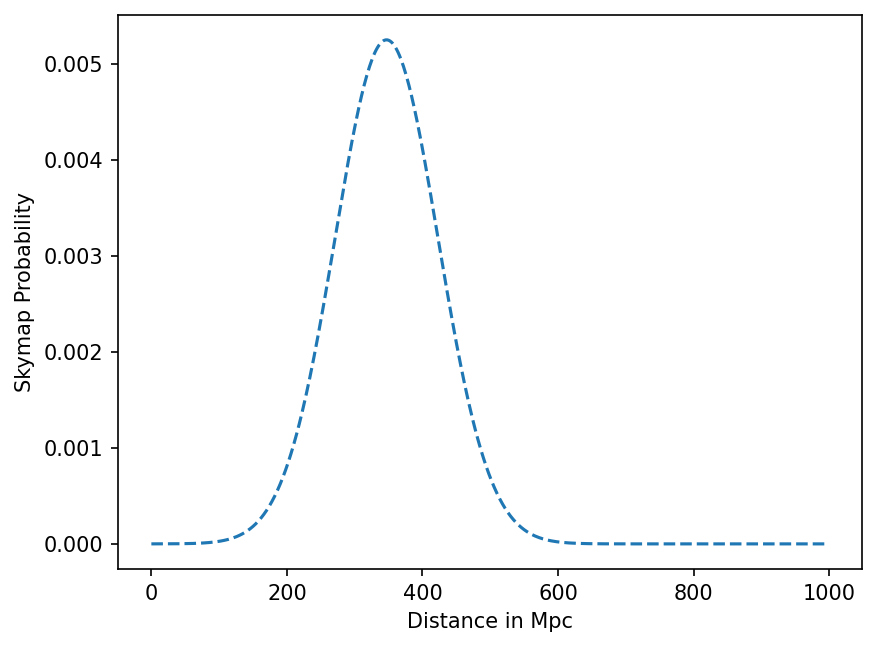

In [22]:
def gauss(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp( - (x-mu)**2 / (2 * sigma**2) )

plt.figure( dpi=150)
plt.plot(np.arange(0, 1000,2) , gauss(np.arange(0, 1000,2), 347, 76), ls='--')
plt.xlabel('Distance in Mpc')
plt.ylabel('Skymap Probability')

In [ ]:
347,

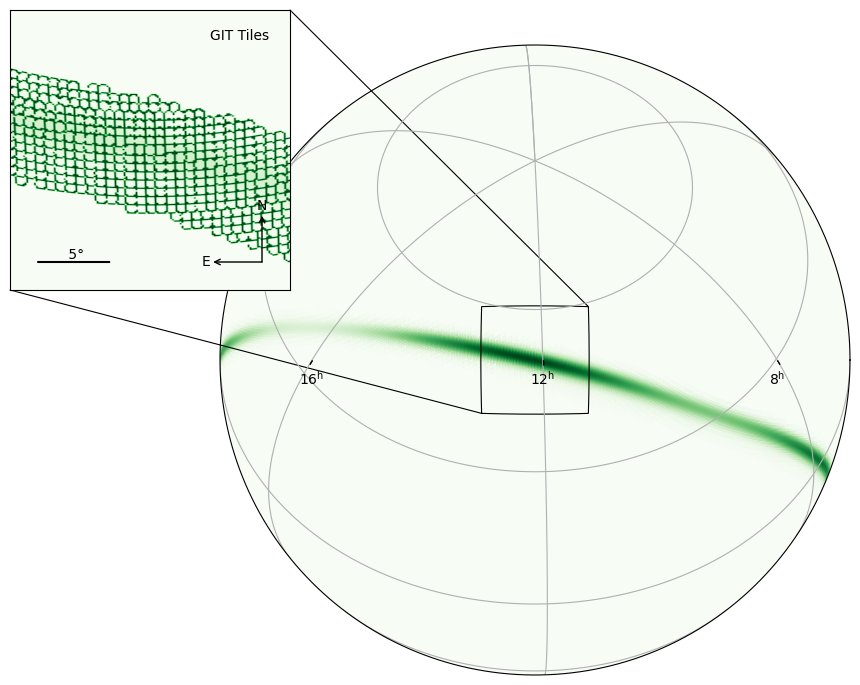

In [9]:
z_catmass, z_missmass = z2, z1

rad = 10

center = SkyCoord(ralist[tt[0]], declist[tt[0]], unit='deg')
fig = plt.figure(figsize=(7, 7), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)




ax_inset4 = plt.axes(
    [-0.25, 0.6, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=rad*u.deg)

plt.text(200,250, 'GIT Tiles')

for key in ['ra', 'dec']:
    ax_inset4.coords[key].set_ticklabel_visible(False)
    ax_inset4.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset4)
ax.connect_inset_axes(ax_inset4, 'upper right')
ax.connect_inset_axes(ax_inset4, 'lower left')
ax_inset4.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset4.compass(0.9, 0.1, 0.2)



cm = 'Greens'
ax.imshow_hpx(skymap, cmap=cm)
#vm = np.max(z_3dfill)
#ax_inset1.imshow_hpx(z_3dfill, cmap=cm, vmin=0,vmax=vm)
#ax_inset2.imshow_hpx(z_2dcat, cmap=cm)#, vmin=0,vmax=vm*1e3)
#ax_inset3.imshow_hpx(z_missmass, cmap=cm, vmin=0,vmax=vm)
#ax_inset4.imshow_hpx(rings, cmap='Blues', vmin=0,vmax=np.max(skymap))
ax_inset4.imshow_hpx(skymap, cmap=cm,vmin=0,vmax=4*np.max(skymap))
ax_inset4.imshow_hpx(rings, cmap=cm, vmin=0)#,vmax=np.max(skymap))
#ax.colorbar()